# Predicting the directional and future price of bitcoin.

**OVERVIEW**

Predicting the future price for bitcoin.  Firstly, predicting whether the bitcoin price will decline or increase in value, and for what time frames.  And secondly, predicting the actual future price of bitcoin, for a time frame.


### Data Sources
Data sources include free and paid bitcoin historical data.  And may include additional data sets, as required.  

Providing bitcoin historical prices, volume data, technical indicators (RSI), open interest ratios, liquidity levels, the order book, on chain activity, options and their expirations, and market sentiment.  

*Including these data sources:*
- https://github.com/ff137/bitstamp-btcusd-minute-data
- https://finance.yahoo.com
- https://www.bybit.com/future-activity/en/developer
- https://hyblockcapital.com/api-explorer
- https://api.santiment.net


### Data Understanding

Data Consists of Bitmex historical price data in minutes, for Bitcoin.  For **1/1/2012** thru **4/18/2024**.  

*And includes the following columns:*
- timestamp, date and time of the transaction
- open, opening price of bitcoin
- low, low price of bitcoin
- high, high price of bitcoin
- close, close price of bitcoin

Taken from: https://github.com/ff137/bitstamp-btcusd-minute-data

**Additional Data** has been added from: https://finance.yahoo.com

*And includes the following columns:*
- MSTR, Microstrategy Daily Close Price
- ETH-USD, Ethereum Daily Close Price
- ^SPX, Standard and Poor 500 Daily Close Prie




#### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import train_test_split

from pmdarima import auto_arima, ARIMA, model_selection
import yfinance as yf

import seaborn as sns

#### Useful functions for plotting and Data Manipulation

In [2]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Plot training, test, and forecasts
  plt.figure(figsize = (10,4))
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = mean_squared_error(test, predictions, squared = False)
  mape = mean_absolute_percentage_error(test, predictions)

  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

# Function to plot the future
def plot_future(y, forecast, title):
  # Plot training and forecasts
  plt.figure(figsize = (10,4))
  plt.plot(y, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  plt.title(f"Train and Forecast with {title}")
  plt.legend()
  plt.show()

# Function to Add the asset's daily closing price as a column to the dataframe
def add_column_with_asset_close(ticker):
    # Account for gap days with the forward fill.  stocks do not trade 24/7, like bitcoin does.
    asset = yf.download(ticker, start="2011-12-30", end="2025-04-18", interval="1d", progress=False, group_by='ticker', auto_adjust=True)  
    asset_close = asset[ticker]['Close'].asfreq('D').ffill()

    column_name = ticker.lower() + ''
    
    asset_close.name = column_name
    df[column_name] = asset_close
    df[column_name] = df[column_name].ffill()    


#### Load the Data

In [3]:
# Load historical and recent data
DATA_DIR = 'data/'
df_hist = pd.read_csv(
    f'{DATA_DIR}btcusd_bitstamp_1min_2012-2025.csv.gz',
    compression='gzip'
)
df_recent = pd.read_csv(
    f'{DATA_DIR}btcusd_bitstamp_1min_latest.csv'
)

# Combine the datasets
df = pd.concat([df_hist, df_recent], ignore_index=True)



### Data Exploration
Bitcoin Pricing Data is in minute data.  Data has been cleaned and validated.  Missing data has been added. 

By using pricing data from https://github.com/ff137/bitstamp-btcusd-minute-data

Duplicates if any will be dropped.  The data will be transformed to daily, rather than minute data.  And correlated assets will be added.


In [4]:
# Information about the df
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6992075 entries, 0 to 6992074
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   open       float64
 2   high       float64
 3   low        float64
 4   close      float64
 5   volume     float64
dtypes: float64(5), int64(1)
memory usage: 320.1 MB


,timestamp,open,high,low,close,volume
0,1325412060,4.58,4.58,4.58,4.58,0.0
1,1325412120,4.58,4.58,4.58,4.58,0.0
2,1325412180,4.58,4.58,4.58,4.58,0.0
3,1325412240,4.58,4.58,4.58,4.58,0.0
4,1325412300,4.58,4.58,4.58,4.58,0.0


#### Clean and Prepare the Data

In [5]:
#Check for Missing Values
missing_counts = df.isnull().sum().sort_values()
print(missing_counts)

# drop nulls, if any
df = df.dropna()

df.info()

# Remove duplicates, if any.
print("Before removing duplicates:", df.shape)

df = df.drop_duplicates()
print("After removing duplicates:", df.shape)

timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6992075 entries, 0 to 6992074
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   open       float64
 2   high       float64
 3   low        float64
 4   close      float64
 5   volume     float64
dtypes: float64(5), int64(1)
memory usage: 320.1 MB
Before removing duplicates: (6992075, 6)
After removing duplicates: (6992075, 6)


In [6]:
# convert unix timestamp to datetime timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') # timestamp is in seconds

# set the datetime timestamp to the index - for date comparison analysis
df.set_index('timestamp', inplace=True)

# avg, initial values - will be calculated with resample below - increases MAPE to 1.98 from 1.92
df['avg_open'] = df['open']
df['avg_close'] = df['close']

# Resample to daily, account for how these fields should be Aggregated.  open, high, low, close and volume.
df = df.resample('D').agg({
    'open': 'first',
    'avg_open': 'mean',
    'high': 'max',
    'low':  'min',
    'close': 'last',
    'avg_close': 'mean',
    'volume': 'sum'
})

#### Add Correlated Assets 
- Micro Strategy Stock, Daily Closing Prices 
- Ethereum crypto currency, Daily Closing Prices
- S&P500 Index, Daily Closing Prices

In [7]:
TICKERS = ['MSTR', 'ETH-USD', '^SPX']
for ticker in TICKERS:
    add_column_with_asset_close(ticker)

#### Target 'y' is the next day's closing price, 

In [8]:
df['y'] = df['close'].shift(-1) # target y, we want to predict with historical open, close... tomorrow's 'close'

# drop last row, to avoid 0 value
df = df[:-1] 

# final data cleanup, not all assets added have data.  For example, ethereum wasn't traded until 2015, and we have bitcoin data since 2012
df = df.fillna(0)

df.tail()

,open,avg_open,high,low,close,avg_close,volume,mstr,eth-usd,^spx,y
timestamp,,,,,,,,,,,
2025-04-13,85277.0,84443.513889,86084.0,83031.0,83712.0,84435.621528,1210.922231,299.980011,1596.685791,5363.359863,84583.0
2025-04-14,83774.0,84667.644444,85787.0,83680.0,84583.0,84661.682639,1425.881757,311.450012,1622.769897,5405.970215,83686.0
2025-04-15,84583.0,85019.756250,86450.0,83612.0,83686.0,85018.299306,1162.911798,310.720001,1588.632446,5396.629883,84046.0
2025-04-16,83632.0,84005.183333,85528.0,83102.0,84046.0,84001.820139,1593.448399,311.660004,1578.105347,5275.700195,84954.0
2025-04-17,84045.0,84578.220833,85478.0,83751.0,84954.0,84575.286806,1119.587824,317.200012,1582.548340,5282.700195,84864.0


### Exploratory Data Analysis

#### Explore Correlations

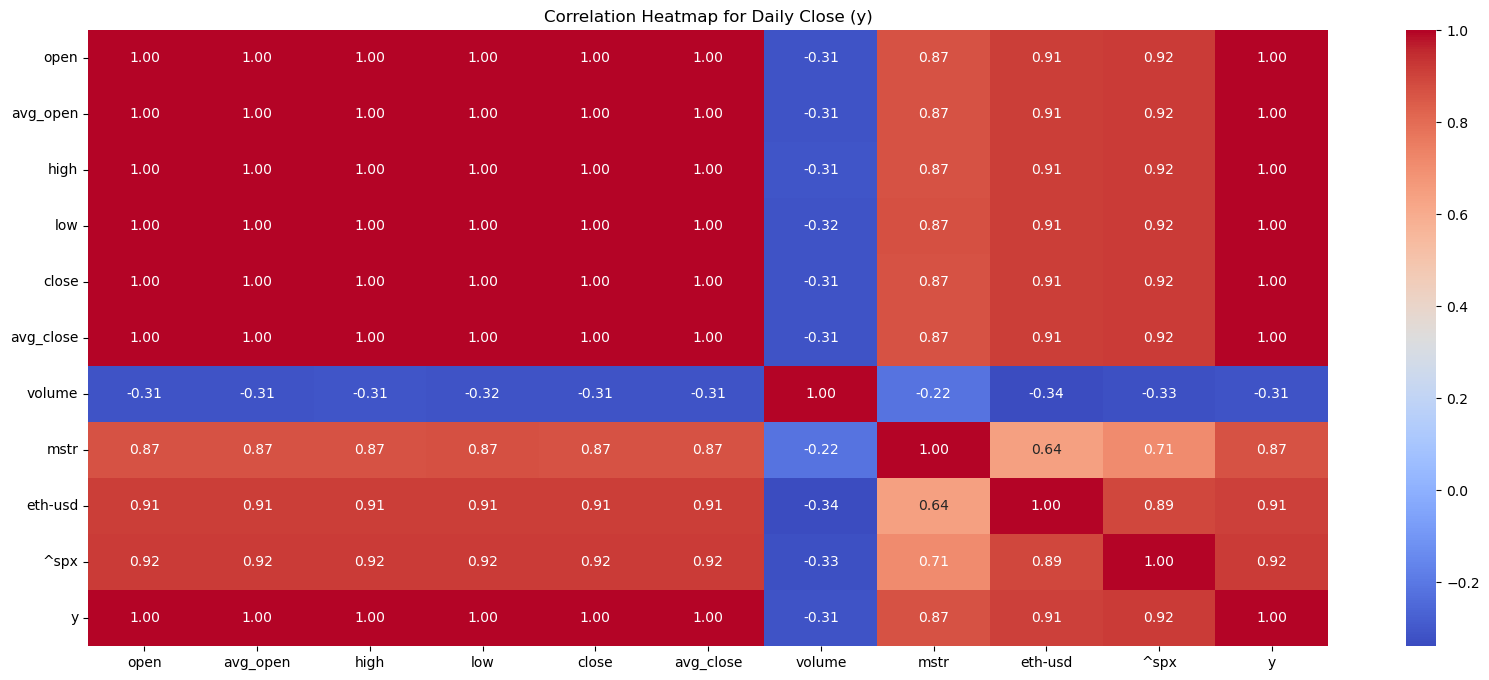

In [9]:
# heatmap of correlation matrix
numerical_subset_df = df.select_dtypes(include=['int64', 'float64'])
corr = numerical_subset_df.corr()

plt.figure(figsize=(20, 8))  # Adjust the size as needed
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation Heatmap for Daily Close (y)')
plt.show()

#### Plots of the Closing Price - 'y' target 

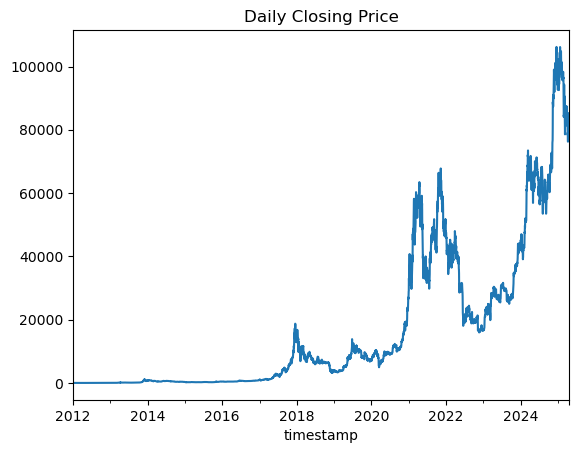

In [10]:
# Daily Closing Price  Plot
df['y'].plot(title = 'Daily Closing Price')
plt.show()

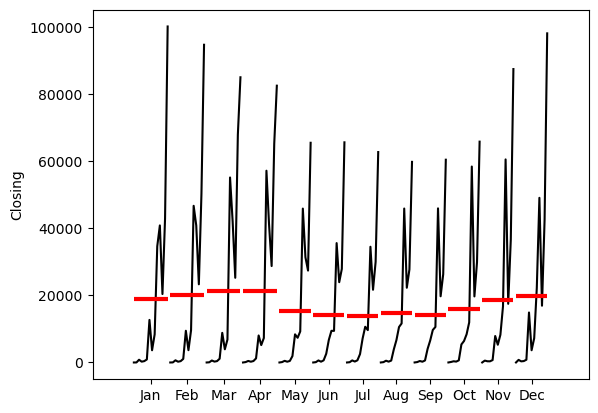

In [11]:
# Plotting the monthly seasonality
month_plot(df['y'].resample('ME').mean(),
           ylabel = 'Closing')
plt.show()

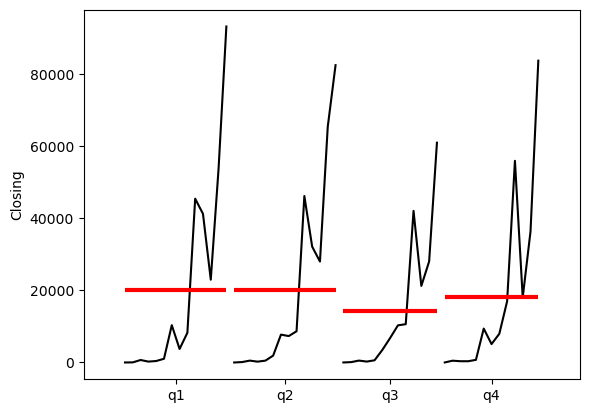

In [12]:
# Plotting the quarterly seasonality
quarter_plot(df['y'].resample('QE').mean(),
           ylabel = 'Closing')
plt.show()

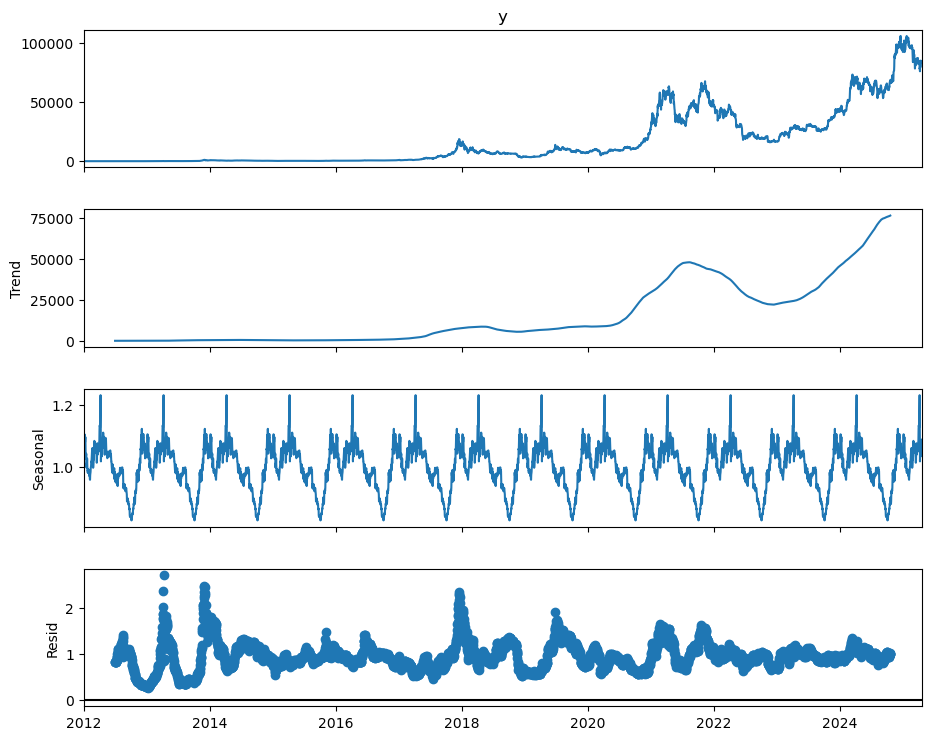

In [13]:
# Seasonal Decomposition Plots for Bitcoin Data
decomposition = seasonal_decompose(df['y'],
                                   model = 'mul',
                                   period = 365)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

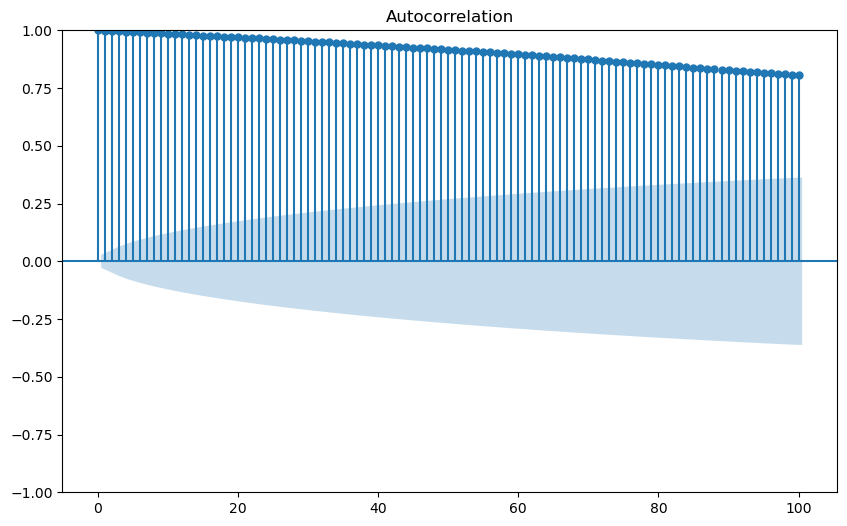

In [14]:
# Plot the autocorrelation (ACF)
fig, ax = plt.subplots(figsize = (10,6))
plot_acf(df['y'], lags = 100, ax = ax)
plt.show()

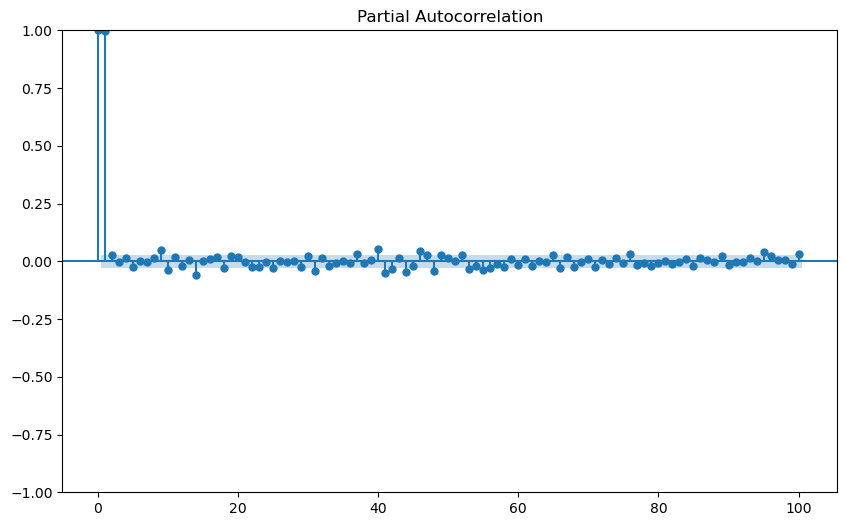

In [15]:
# Plot the partial autocorrelation (PACF)
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['y'], lags = 100, ax = ax)
plt.show()

### Feature Engineering

An initial model, for predicting Bitcoin's future price.

In [16]:
X = df.drop(['y'], axis=1)
y = df['y']  # target variable

In [17]:
# Train/Test, 20% for Test.  Split the data - shuffle off - timeseries, in order... a chronological split.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#### Initial Base Model to Beat, **SARIMAX** on a weekly period

In [19]:
# sarimax, 7 day period

In [20]:
model_sarimax = auto_arima(y_train,
                           m = 7,
                           X = X_train)
model_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3884
Model:               SARIMAX(5, 0, 4)   Log Likelihood              -30922.626
Date:                Thu, 24 Apr 2025   AIC                          61885.252
Time:                        07:53:12   BIC                          62010.544
Sample:                    01-01-2012   HQIC                         61929.731
                         - 08-19-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
open           0.0649      0.062      1.049      0.294      -0.056       0.186
avg_open      38.6070     14.287      2.702      0.007      10.605      66.610
high           0.3181      0.023     13.943      0.000       0.273       0.363
low            0.2802      0.015     18.344      0.000       0.250       0.310
close          0.9148      0.060     15.260      0.000       0.797       1.032
avg_close    -39.1789     14.284     -2.743      0.006     -67.174     -11.183
volume         0.0002      0.002      0.077      0.938      -0.004       0.004
mstr           4.9326      1.129      4.370      0.000       2.720       7.145
eth-usd       -0.1638      0.020     -8.189      0.000      -0.203      -0.125
^spx          -0.0252      0.013     -1.876      0.061      -0.051       0.001
ar.L1          0.5487      0.163      3.369      0.001       0.230       0.868
ar.L2         -0.5628      0.095     -5.951      0.000      -0.748      -0.377
ar.L3         -0.4837      0.100     -4.839      0.000      -0.680      -0.288
ar.L4          0.2105      0.147      1.436      0.151      -0.077       0.498
ar.L5         -0.0499      0.012     -4.249      0.000      -0.073      -0.027
ma.L1         -0.5527      0.187     -2.952      0.003      -0.920      -0.186
ma.L2          0.5430      0.108      5.023      0.000       0.331       0.755
ma.L3          0.4478      0.118      3.803      0.000       0.217       0.679
ma.L4         -0.1577      0.148     -1.063      0.288      -0.448       0.133
sigma2      4.878e+05      0.012   3.99e+07      0.000    4.88e+05    4.88e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             57843.66
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):            1283.68   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.45e+22. Standard errors may be unstable.
"""

#### Forecast using SARIMAX Model

In [21]:
# Use the fitted Sarimax model to forecast future values.
predictions_arima = model_sarimax.predict(X=X_test, n_periods = len(X_test)) # set the number of periods to forecast to the length of 'test'
predictions_arima

2022-08-20    21128.721851
2022-08-21    21453.299696
2022-08-22    20776.358386
2022-08-23    21148.718008
2022-08-24    21674.413296
                  ...     
2025-04-13    85861.300196
2025-04-14    86495.373665
2025-04-15    85543.461714
2025-04-16    86039.283362
2025-04-17    86744.488621
Freq: D, Length: 972, dtype: float64

#### SARIMAX Model Assessment

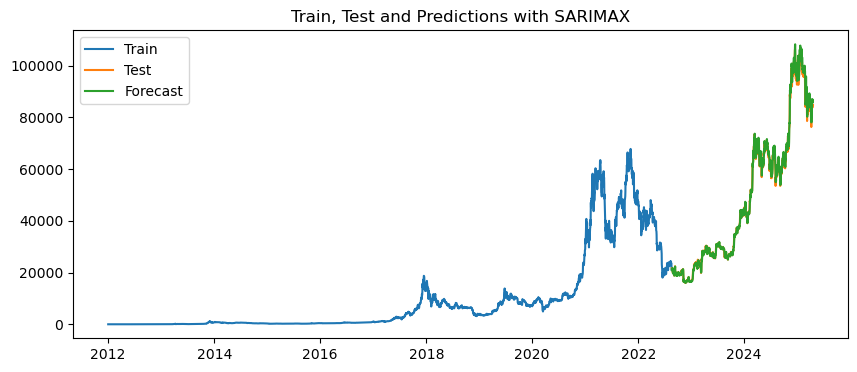

The MAE is 1044.01
The RMSE is 1636.12
The MAPE is 1.98 %


In [22]:
# Model assessment
model_assessment(y_train, y_test, predictions_arima, "SARIMAX")